In [1]:
import torch
import pickle
import numpy as np
import pandas as pd
import os
from typing import Tuple
import gymnasium as gym
import combinatorial_problems
from tqdm import tqdm

In [2]:
def load_experiment(directory: str,
                    experiment_name: str
                    ) -> Tuple[torch.nn.Module, dict]:
    # Create experiment files
    exp_pt_file = os.path.join(directory, f'{experiment_name}.pt')
    exp_pkl_file = os.path.join(directory, f'{experiment_name}.pkl')
    
    # Load torch models and experiment data
    model = torch.load(exp_pt_file)
    with open(exp_pkl_file, 'rb') as jar:
        data = pickle.load(jar)
    return model, data

## Load Experiment Model and Data

In [11]:
experiment_directory = "./results/"
exp_50_baseline_file = 'experiment_baseline_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_epochs_6250_batch-len_128_problem_TSP_nodes_50_dim_2'
exp_50_persist_file = 'experiment_0_PAM_heads_8_layers_3_g-embedding_p_lr_0.0001_epochs_500_batch-len_64_problem_TSP_nodes_50_dim_2'
exp_20_baseline_file = 'experiment_1_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_256000_epochs_75_batch-len_512_problem_TSP_nodes_20_dim_2'
exp_20_persist_file_10_epoch = 'experiment_0_PAM_heads_8_layers_3_g-embedding_p_lr_0.0001_envs_153600_epochs_10_batch-len_512_problem_TSP_nodes_20_dim_2'

In [12]:
exp_50_baseline = load_experiment(experiment_directory, exp_50_baseline_file)
exp_50_persist = load_experiment(experiment_directory, exp_50_persist_file)
exp_20_baseline = load_experiment(experiment_directory, exp_20_baseline_file)
exp_20_persist_10_epoch = load_experiment(experiment_directory, exp_20_persist_file_10_epoch)

# Explore Performance on Different Problems

In [5]:
baseline_model = exp_50_baseline[0]
baseline_model=baseline_model.eval()
persistence_model = exp_50_persist[0]
persistence_model=persistence_model.eval()
baseline_model_20 = exp_20_baseline[0]
baseline_model_20 = baseline_model_20.eval()
baseline_model_20_10_epoch = exp_20_persist_10_epoch[0]
baseline_model_20_10_epoch = exp_20_persist_10_epoch.eval()

In [7]:
def evaluate_TSP(model: torch.nn.Module,
                 graph_size: int,
                 batch_size: int,
                 eval_epochs: int):
    problem_env = "combinatorial_problems/TravelingSalesman-v0"
    env = gym.vector.make(problem_env,
                num_nodes=graph_size,
                num_envs=batch_size,
                new_on_reset=True,
                asynchronous=False)
    rewards_over_batches = []
    for epoch in tqdm(range(eval_epochs)):
        state, info = env.reset()
        start_idx = info["agent_start_idx"]
        end_idx = start_idx
        done = False
        batch_rewards = 0
        while not done:
            graph_nodes = np.stack(info["nodes"])
            graph = torch.FloatTensor(graph_nodes).reshape(batch_size, graph_size, 2).to('cuda')

            tmp_emb = model.policy.encoder(graph).detach()
            start_node = tmp_emb[np.arange(batch_size), start_idx, :].unsqueeze(1)
            end_node = tmp_emb[np.arange(batch_size), end_idx, :].unsqueeze(1)
            ctxt = torch.cat([start_node, end_node], dim=-1)
            mask_emb_graph = torch.zeros(batch_size, 1, graph_size).bool().to('cuda')  # Empty Mask!
            masks = np.stack(info["mask"])
            mask_dec_graph = torch.tensor(masks).unsqueeze(1).to('cuda')
            reuse_embeding = False

            # Only use with older model:
            #model.policy.reuse_graph_emb = False

            with torch.no_grad():
                action = model(graph=graph,
                              ctxt=ctxt,
                              mask_emb_graph=mask_emb_graph,
                              mask_dec_graph=mask_dec_graph,
                              reuse_embeding=reuse_embeding,
                              explore=True,
                              re_compute_embedding=False).numpy()
            state, reward, terminated, truncated, info = env.step(action)
            end_idx = action.squeeze()
            batch_rewards += reward
            done = terminated.all() or truncated.all()
        rewards_over_batches.append(np.array(batch_rewards).mean())
        model.policy.graph_emb_vect = None
    eval_rewards = np.mean(rewards_over_batches)
    return eval_rewards

In [9]:
# Baseline model trained on 20 nodes
model = baseline_model_20
model.policy.batches = None
evaluate_TSP(model=model, 
             graph_size=50,
             batch_size=32,
             eval_epochs=10)

100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


-8.4653465326852

## Plots

<AxesSubplot:>

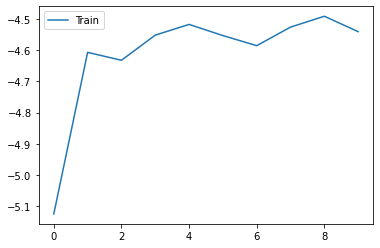

In [15]:
exp_20_baseline[1]['rewards'][:10].plot()

<AxesSubplot:>

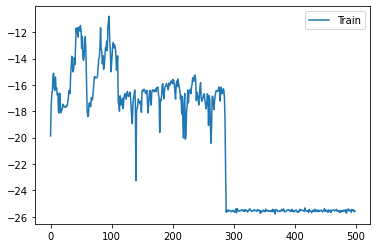

In [9]:
exp_50_persist[1]['rewards'].plot()

<AxesSubplot:>

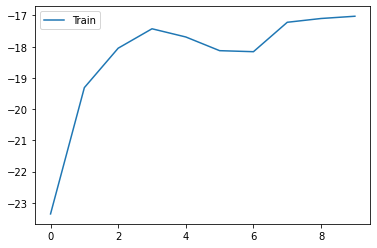

In [14]:
exp_50_baseline[1]['rewards'][:10].plot()

<AxesSubplot:>

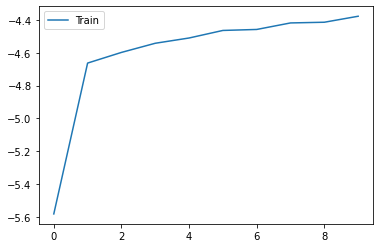

In [13]:
exp_20_persist_10_epoch[1]['rewards'].plot()